In [1]:
from neo.core import SpikeTrain
from scipy.spatial import distance_matrix
from scipy.stats import pearsonr,wilcoxon,mannwhitneyu
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import rand_score
from scipy import ndimage
from statannotations.Annotator import Annotator
from tqdm import tqdm
import elephant as eph
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import quantities as q
import seaborn as sns
import time

import sys
sys.path.append("..")
from utils import *

%config Completer.use_jedi = False

if not os.path.exists('__datacache__'):
    os.makedirs('__datacache__')
if not os.path.exists('AnalysedData'):
    os.makedirs('AnalysedData')

recalculate = False

In [2]:
def get_connectivity_timeseries(mat_no,odor_no,replicate,switch_prob = 0.3):
    n_n = 120
    p_n = 90
    l_n = 30

    pPNPN = 0.0
    pPNLN = 0.1
    pLNPN = 0.2

    ach_mat = np.zeros((n_n,n_n))
    np.random.seed(64163+mat_no) # Random.org
    ach_mat[p_n:,:p_n] = np.random.choice([0.,1.],size=(l_n,p_n),p=(1-pPNLN,pPNLN))
    ach_mat[:p_n,:p_n] = np.random.choice([0.,1.],size=(p_n,p_n),p=(1-pPNPN,pPNPN))
    
    PNLN = ach_mat[p_n:,:p_n]
    
    LNPN = np.zeros((p_n,l_n))
    stride = int(p_n/l_n)
    spread = (round(pLNPN*p_n)//2)*2+1 # Round to closest odd integer
    center = 0
    index = np.arange(p_n)
    for i in range(l_n):
        idx = index[np.arange(center-spread//2,1+center+spread//2)%p_n]
        LNPN[idx,i] = 1
        center+=stride

    fgaba_mat = np.zeros((n_n,n_n))
    fgaba_mat[:p_n,p_n:] = LNPN # LN->PN
    fgaba_mat[p_n:,p_n:] = np.loadtxt(f'../modules/networks/matrix_{mat_no}.csv',delimiter=',') # LN->LN
    np.fill_diagonal(fgaba_mat,0.)

    sgaba_mat = np.zeros((n_n,n_n))
    sgaba_mat[:p_n,p_n:] = LNPN
    np.fill_diagonal(sgaba_mat,0.)

    blocktime = 12000 # in ms
    buffer = 500 # in ms
    sim_res = 0.01 # in ms
    min_block = 50 # in ms

    np.random.seed(mat_no+odor_no+replicate)
    if switch_prob == 0.0:
        sw_state = [1]
    else:
        sw_state = [0]

    for i in np.random.choice([0,1],p=[1-switch_prob,switch_prob],size=int(blocktime/min_block)-1):
        if i==1:
            sw_state.append(1-sw_state[-1])
        else:
            sw_state.append(sw_state[-1])
    ts = np.repeat(sw_state,int(min_block/sim_res))
    
    sim_time = blocktime + 2*buffer
    t = np.arange(0,sim_time,sim_res)
    np.random.seed(odor_no)
    setpn = np.concatenate([np.ones(9),np.zeros(81)])
    np.random.shuffle(setpn)
    ts = np.concatenate([np.zeros(int(buffer/sim_res)),ts,np.zeros(int(buffer/sim_res))])
    return PNLN,LNPN,setpn,t,ts

def get_traces(mat_no,odor_no,replicate):
    return np.load(f"__datacache__/data_{mat_no}_{odor_no}_{replicate}.npy")

def get_LN_data(mat_no,odor_no,replicate=None):
    r = []
    mat = np.loadtxt(f'../modules/networks/matrix_{mat_no}.csv',delimiter=",")
    module = np.loadtxt(f'../modules/networks/matrix_{mat_no}_modules.csv')
    order = np.argsort(module)
    if replicate is None:
        for i in filter(lambda v: ".npy" in v and f"{mat_no}_{odor_no}" in v,os.listdir("__datacache__")):
            temp = np.load(f"__datacache__/{i}").T
            spikes = np.logical_and(temp[90:,1:]>=-20,temp[90:,:-1]<-20)
            event = np.array([SpikeTrain(np.linspace(0,12.998,12999)[k>0]*q.s,t_stop=13*q.s) for k in spikes],dtype=object)
            bst = eph.conversion.BinnedSpikeTrain(list(event),bin_size=50*q.ms)
            pearson_correlation = eph.spike_train_correlation.correlation_coefficient(bst)
            r.append(pearson_correlation[:,order][order,:])
    else:
        temp = np.load(f"__datacache__/data_{mat_no}_{odor_no}_{replicate}.npy").T
        spikes = np.logical_and(temp[90:,1:]>=-20,temp[90:,:-1]<-20)
        event = np.array([SpikeTrain(np.linspace(0,12.998,12999)[k>0]*q.s,t_stop=13*q.s) for k in spikes],dtype=object)
        bst = eph.conversion.BinnedSpikeTrain(list(event),bin_size=50*q.ms)
        pearson_correlation = eph.spike_train_correlation.correlation_coefficient(bst)
        r.append(pearson_correlation[:,order][order,:])
    return np.nan_to_num(np.array(r)),mat[:,order][order,:],module[order],order
    
def get_module_vector(pn,LNPN,module,order):
    temp = module[(LNPN[pn,:]==1)]
    vec = np.zeros(int(np.max(module)))
    for i in range(1,int(np.max(module))+1):
        vec[i-1] = np.sum(temp==i)
    return vec

def get_PN_data(mat_no,odor_no,replicate=None):
    spike_dist = []
    mat = np.loadtxt(f'../modules/networks/matrix_{mat_no}.csv',delimiter=",")
    module = np.loadtxt(f'../modules/networks/matrix_{mat_no}_modules.csv')
    order = np.argsort(module)
    PNLN,LNPN,setpn,_,_ = get_connectivity_timeseries(mat_no,odor_no,1)
    module_space = [get_module_vector(i,LNPN=LNPN,module=module,order=order) for i in np.arange(90)[setpn==1]]
    module_dist = distance_matrix(module_space,module_space)
    for i in filter(lambda v: ".npy" in v and f"{mat_no}_{odor_no}" in v,os.listdir("__datacache__")):
        temp = np.load(f"__datacache__/{i}").T
        spikes = np.logical_and(temp[:90,1:]>=0.,temp[:90,:-1]<0.)
        event = [SpikeTrain(np.linspace(0,12.998,12999)[k>0]*q.s,t_stop=13*q.s) for k in spikes[np.arange(90)[setpn==1]]]
        distance = eph.spike_train_dissimilarity.van_rossum_dist(event,tau=50*q.ms)
        spike_dist.append(distance)
    return np.array(spike_dist),module_dist

def odor_analysis(mat_no,time=None):
    r = []
    mat = np.loadtxt(f'../modules/networks/matrix_{mat_no}.csv',delimiter=",")
    module = np.loadtxt(f'../modules/networks/matrix_{mat_no}_modules.csv')
    order = np.argsort(module)
    for odor in [13674, 59428, 72957, 84932, 85036]:
        for replicate in range(1,11):
            temp = np.load(f"__datacache__/data_{mat_no}_{odor}_{replicate}.npy").T
            timeseries = np.linspace(0,12.998,12999)
            endpoint = 13*q.s
            if time is not None:
                temp = temp[:,:int(time*1000)]
                endpoint = time*q.s
                timeseries = np.linspace(0,(int(time*1000)-2)/1000,int(time*1000)-1)
            spikes = np.logical_and(temp[90:,1:]>=-20,temp[90:,:-1]<-20)
            event = [SpikeTrain(([0]+list(timeseries[k>0]))*q.s,t_start=0*q.s,t_stop=endpoint) for k in spikes]
            bst = eph.conversion.BinnedSpikeTrain(list(event),bin_size=50*q.ms)
            pearson_correlation = eph.spike_train_correlation.correlation_coefficient(bst)
            r.append(pearson_correlation[:,order][order,:])
    N = len(r)
    r = np.array(r)
    corr_mat = np.ones((N,N))
    for i in range(N):
        for j in range(i):
            corr_mat[i,j] = pearsonr(r[i].flatten(),r[j].flatten())[0]
            corr_mat[j,i] = corr_mat[i,j]
    within = []
    across = []
    for i in range(N//10):
        for j in range(i+1):
            temp = corr_mat[10*i:10*i+10,10*j:10*j+10]
            if i==j:
                within.append(temp[np.tril_indices(10,-1)].flatten())
            else:
                across.append(temp.flatten())
    within = np.concatenate(within)
    across = np.concatenate(across)
    return corr_mat,within[~np.isnan(within)],across[~np.isnan(across)]

# Intermittency Schematic (Fig 7a)

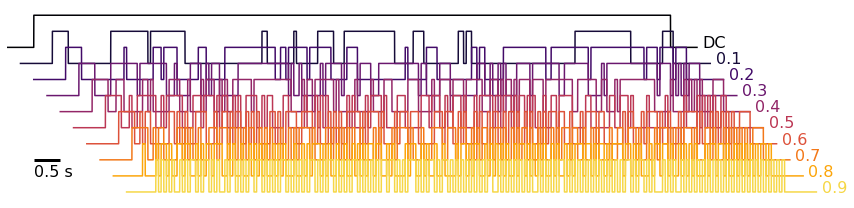

In [3]:
fig,ax = plt.subplots(1,1,figsize=(12,3))
for n, i in enumerate(np.arange(0.0,1,0.1)):
    PNLN,LNPN,setpn,t,ts = get_connectivity_timeseries(2,59428,1,switch_prob=i)
    plt.plot(0.25*n+t/1000,-0.5*n+ts,'k',linewidth=1.5,color=plt.cm.inferno(n/10.))
    if i==0.0:
        plt.text(13.1+0.25*n,-0.5*n,"DC",fontdict={"fontsize":16},color=plt.cm.inferno(n/10.))
    else:
        plt.text(13.1+0.25*n,-0.5*n,f"{i:0.1f}",fontdict={"fontsize":16},color=plt.cm.inferno(n/10.))
plt.hlines(-3.5,0.5,1.0,color='k',linewidth=3)
plt.text(0.5,-4,"0.5 s",fontdict={"fontsize":16})
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlim(0,15.6)
plt.box(False)
plt.tight_layout()
plt.savefig(f"Figures/IntemittentTimeseries.svg")

# Structure-Dynamics across Intermittency (FIg 7b,c,d)

In [4]:
if recalculate:
    clean_data_cache()
    for switch_prob in np.arange(0.0,0.05,0.1):
        fetch_data(switch_prob)
        results = []
        for i in tqdm(range(1,11)):
            for j in [13674, 59428, 72957, 84932, 85036]:
                LN_correlations,mat,module,order = get_LN_data(i,j)
                for k in range(10):
                    correlation = np.corrcoef(np.nan_to_num(LN_correlations[k]).flatten(),1-mat.flatten())[0,1]
                    random_shuffles = [np.random.choice(np.arange(30),size=30,replace=False) for x in range(1000)]
                    shuffled = np.mean([np.corrcoef(np.nan_to_num(LN_correlations[k]).flatten(),1-mat[:,order][order,:].flatten())[0,1] for order in random_shuffles])
                    results.append((correlation,shuffled))
        results=np.real(np.array(results))
        results = pd.DataFrame(results,columns=["Original","Shuffled"])
        results.to_csv(f"AnalysedData/LNCorrelationAnalysis_0_{int(switch_prob*10)}.csv")

        results = []
        for i in tqdm(range(1,11)):
            for j in [13674, 59428, 72957, 84932, 85036]:
                LN_correlations,mat,module,order = get_LN_data(i,j)
                for k in range(10):
                    cluster_model = KMeans(n_clusters=int(np.max(module)))
                    cluster_model.fit((1-LN_correlations[k])/2)
                    f_correctpairs = rand_score(cluster_model.labels_,np.int32(module-1))
                    random_clustering = [np.random.choice(np.arange(4),size=30) for x in range(1000)]
                    shuffled = np.mean([rand_score(cluster_model.labels_,cluster) for cluster in random_clustering])
                    results.append((f_correctpairs,shuffled))
        results = np.real(np.array(results))
        results = pd.DataFrame(results,columns=["Newman","Random"])
        results.to_csv(f"AnalysedData/LNReconstructionAnalysis_0_{int(switch_prob*10)}.csv")

        results = []
        for i in tqdm(range(1,11)):
            for j in [13674, 59428, 72957, 84932, 85036]:
                spike_dist,module_dist = get_PN_data(i,j)
                for k in range(10):
                    correlation = np.corrcoef(np.nan_to_num(spike_dist[k]).flatten(),module_dist.flatten())[0,1]
                    random_shuffles = [np.random.choice(np.arange(9),size=9,replace=False) for x in range(1000)]
                    shuffled = np.mean([np.corrcoef(np.nan_to_num(spike_dist[k]).flatten(),module_dist[:,order][order,:].flatten())[0,1] for order in random_shuffles])
                    results.append((correlation,shuffled))
        results=np.real(np.array(results))
        results = pd.DataFrame(results,columns=["Original","Shuffled"])
        results.to_csv(f"AnalysedData/PNCorrelationAnalysis_0_{int(switch_prob*10)}.csv")

        results= [[],[]]
        for i in tqdm(range(1,11)):
            summary_matrix,within,across = odor_analysis(i)
            for j in within:
                results[0].append(j)
            for j in across:
                results[1].append(j)
        N = max(len(results[0]),len(results[1]))
        temp = np.nan*np.ones((N,2))
        temp[:len(results[0]),0] = results[0]
        temp[:len(results[1]),1] = results[1]
        results=np.real(temp)
        results = pd.DataFrame(results,columns=["Within","Across"])
        results.to_csv(f"AnalysedData/OdorComparision_0_{int(switch_prob*10)}.csv")

        results= []
        for time in tqdm(np.arange(0.5,13.5,0.5)):
            for i in range(1,11):
                _,within,across = odor_analysis(i,time=time)
                for j in within:
                    if not np.isnan(j):
                        results.append((time,"Within Odors",j))
                for j in across:
                    if not np.isnan(j):
                        results.append((time,"Across Odors",j))
        results=np.real(np.array(results))
        results = pd.DataFrame(results,columns=["Time","LN Dynamics Correlation","Correlation"])
        results['Time'] = np.float32(results['Time'])
        results['Correlation'] = np.float32(results['Correlation'])
        results.to_csv(f"AnalysedData/OdorComparisionTimeseries_0_{int(switch_prob*10)}.csv")

        clean_data_cache()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0_Original vs. 0.1_Original: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.201e-77 Stat=2.056e+03
0.6_Original vs. 0.7_Original: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.000e+00 Stat=6.104e+04
0.7_Original vs. 0.9_Original: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.834e-61 Stat=8.844e+03
0.1_Original vs. 0.6_Original: Wilcoxon test (paired samples) with Bonferroni correction, P_val:6.439e-83 Stat=3.000e+00
0.0_Original vs. 0.6_Original: Wilcoxon test (paired samples) with Bonferroni correction, P_val:6.324e-83 Stat=0.000e+00


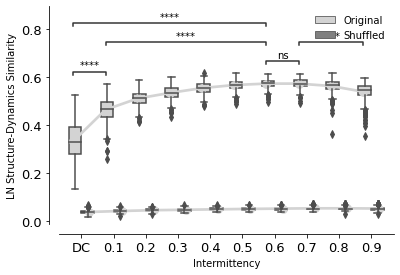

In [5]:
bpx = [((0.0, 'Original'), (0.1, 'Original')),
        ((0.0, 'Original'), (0.6, 'Original')),
        ((0.1, 'Original'), (0.6, 'Original')),
       ((0.7, 'Original'), (0.9, 'Original')),
       ((0.6, 'Original'), (0.7, 'Original'))]

df = pd.DataFrame()
for i in filter(lambda v: "LNCorrelationAnalysis" in v,os.listdir('AnalysedData/')):
    temp = pd.read_csv(f"AnalysedData/{i}",index_col=0)
    temp['Intermittency'] = int(i.split('_')[2][:-4])/10
    df = pd.concat((df,temp))

df = df.melt('Intermittency',var_name="Neuron Order",value_name="Structure-Dynamics Similarity")

plt.figure(figsize=(6,4))
mpl.rc('xtick', labelsize=13) 
mpl.rc('ytick', labelsize=13) 
ax = sns.pointplot(x='Intermittency',y='Structure-Dynamics Similarity', data=df,
              palette='blend:lightgrey,lightgrey',ci=None,capsize=0.1, hue='Neuron Order',dodge=0.5)
plt.setp(ax.lines, zorder=0)
plt.setp(ax.collections, zorder=1, label="")
ax = sns.boxplot(x='Intermittency',y='Structure-Dynamics Similarity',
                 data=df,palette='blend:lightgrey,grey',hue='Neuron Order')#,scale='width',ci='sd',capsize=0.1)
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")
sns.despine(offset=10, trim=False)

annotator = Annotator(ax, bpx, data=df, x='Intermittency',y='Structure-Dynamics Similarity',
                                       hue="Neuron Order", width=1)
annotator.configure(test='Wilcoxon', text_format='star', loc='inside', verbose=2,comparisons_correction='bonferroni')
annotator.apply_and_annotate()
ax.legend(frameon=False)
ax.set_ylabel("LN Structure-Dynamics Similarity")
ax.set_xticklabels(["DC", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9"])
plt.savefig(f"Figures/LNCorrelationAnalysis.svg")

100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Intermittency	p value	Effect Size
DC	****, 6.324e-81	1.000 [95% CI 1.000-1.000]
0.1	****, 6.324e-81	1.000 [95% CI 1.000-1.000]
0.2	****, 6.324e-81	1.000 [95% CI 1.000-1.000]
0.3	****, 6.324e-81	1.000 [95% CI 1.000-1.000]
0.4	****, 6.324e-81	1.000 [95% CI 1.000-1.000]
0.5	****, 6.324e-81	1.000 [95% CI 1.000-1.000]
0.6	****, 6.324e-81	1.000 [95% CI 1.000-1.000]
0.7	****, 6.324e-81	1.000 [95% CI 1.000-1.000]
0.8	****, 6.324e-81	1.000 [95% CI 1.000-1.000]
0.9	****, 6.324e-81	1.000 [95% CI 1.000-1.000]


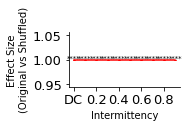

In [6]:
x = []
y = []
pvals = []
p = []
yerr = []
for i in tqdm(np.unique(df.Intermittency)):
    temp = rankbiserial(df[np.logical_and(df.Intermittency==i,df["Neuron Order"]=="Original")]["Structure-Dynamics Similarity"].values,
                    df[np.logical_and(df.Intermittency==i,df["Neuron Order"]=="Shuffled")]["Structure-Dynamics Similarity"].values)
    pval = wilcoxon(df[np.logical_and(df.Intermittency==i,df["Neuron Order"]=="Original")]["Structure-Dynamics Similarity"].values,
                    df[np.logical_and(df.Intermittency==i,df["Neuron Order"]=="Shuffled")]["Structure-Dynamics Similarity"].values).pvalue
    pvals.append(500*pval)
    p.append(to_significance_label(500*pval))
    x.append(i)
    y.append(temp[0])
    yerr.append(temp[1])
    
plt.figure(figsize=(2,1))
plt.errorbar(x,y,yerr=np.abs(np.array(yerr).T-np.tile(y,2).reshape(2,10)),capsize=1,color='red')
for i in range(10):
    plt.text(x[i],np.array(yerr)[:,1][i],p[i],ha='center',fontdict={'size':7})
plt.xticks(np.arange(0.0,1.0,0.2))
plt.xlabel("Intermittency")
plt.ylabel("Effect Size\n(Original vs Shuffled)")
plt.gca().set_xticklabels(["DC",  "0.2",  "0.4",  "0.6",  "0.8"])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.savefig(f"Figures/LNCorrelationAnalysis_effect.svg")

print("Intermittency\tp value\tEffect Size")
for i,n in enumerate(np.unique(df.Intermittency)):
    if n == 0.0:
        print(f"DC\t{p[i]}, {pvals[i]:0.3e}\t{y[i]:0.3f} [95% CI {yerr[i][0]:0.3f}-{yerr[i][1]:0.3f}]")
    else:
        print(f"{n}\t{p[i]}, {pvals[i]:0.3e}\t{y[i]:0.3f} [95% CI {yerr[i][0]:0.3f}-{yerr[i][1]:0.3f}]")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0_Newman vs. 0.1_Newman: Wilcoxon test (paired samples) with Bonferroni correction, P_val:7.070e-18 Stat=2.905e+04
0.6_Newman vs. 0.9_Newman: Wilcoxon test (paired samples) with Bonferroni correction, P_val:6.886e-06 Stat=4.318e+04
0.1_Newman vs. 0.6_Newman: Wilcoxon test (paired samples) with Bonferroni correction, P_val:2.572e-15 Stat=3.027e+04
0.0_Newman vs. 0.6_Newman: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.178e-38 Stat=1.845e+04


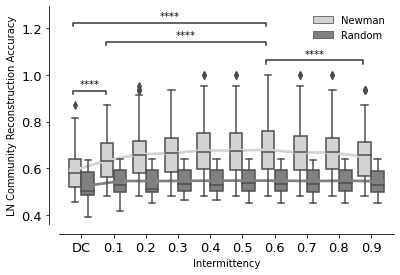

In [7]:
bpx = [((0.0, 'Newman'), (0.1, 'Newman')),((0.0, 'Newman'), (0.6, 'Newman')),((0.1, 'Newman'), (0.6, 'Newman')),
 ((0.6, 'Newman'), (0.9, 'Newman'))]

df = pd.DataFrame()
for i in filter(lambda v: "LNReconstructionAnalysis" in v,os.listdir('AnalysedData/')):
    temp = pd.read_csv(f"AnalysedData/{i}",index_col=0)
    temp['Intermittency'] = int(i.split('_')[2][:-4])/10
    df = pd.concat((df,temp))

df = df.melt('Intermittency',var_name="Clustering Method",value_name="Rand Score")

plt.figure(figsize=(6,4))
mpl.rc('xtick', labelsize=13) 
mpl.rc('ytick', labelsize=13) 
ax = sns.pointplot(x='Intermittency',y='Rand Score', data=df,
              palette='blend:lightgrey,grey',ci=None,capsize=0.1, hue='Clustering Method',dodge=0.5)
plt.setp(ax.lines, zorder=1)
plt.setp(ax.collections, zorder=1, label="")
ax = sns.boxplot(x='Intermittency',y='Rand Score',
                 data=df,palette='blend:lightgrey,grey',hue='Clustering Method')
#                     ,scale='width',ci='sd',capsize=0.1, )
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")
sns.despine(offset=10, trim=False)
annotator = Annotator(ax, bpx, data=df, x='Intermittency',y='Rand Score',
                                       hue="Clustering Method", width=1)
annotator.configure(test='Wilcoxon', text_format='star', loc='inside', verbose=2,comparisons_correction='bonferroni')
annotator.apply_and_annotate()
ax.legend(frameon=False)
ax.set_ylabel("LN Community Reconstruction Accuracy")
ax.set_xticklabels(["DC", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9"])
plt.savefig(f"Figures/LNReconstructionAnalysis.svg")

100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


Intermittency	p value	Effect Size
DC	****, 1.863e-59	0.859 [95% CI 0.824-0.891]
0.1	****, 8.894e-64	0.889 [95% CI 0.858-0.915]
0.2	****, 6.936e-71	0.937 [95% CI 0.915-0.954]
0.3	****, 1.592e-73	0.954 [95% CI 0.937-0.968]
0.4	****, 3.317e-74	0.958 [95% CI 0.942-0.971]
0.5	****, 3.103e-73	0.952 [95% CI 0.935-0.966]
0.6	****, 6.439e-75	0.963 [95% CI 0.948-0.975]
0.7	****, 1.345e-74	0.961 [95% CI 0.945-0.973]
0.8	****, 5.949e-74	0.956 [95% CI 0.940-0.970]
0.9	****, 1.167e-72	0.948 [95% CI 0.930-0.964]


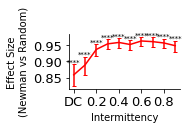

In [8]:
x = []
y = []
yerr = []
p = []
pvals= []
for i in tqdm(np.unique(df.Intermittency)):
    temp = rankbiserial(df[np.logical_and(df.Intermittency==i,df["Clustering Method"]=="Newman")]["Rand Score"].values,
                    df[np.logical_and(df.Intermittency==i,df["Clustering Method"]=="Random")]["Rand Score"].values)
    pval = wilcoxon(df[np.logical_and(df.Intermittency==i,df["Clustering Method"]=="Newman")]["Rand Score"].values,
        df[np.logical_and(df.Intermittency==i,df["Clustering Method"]=="Random")]["Rand Score"].values).pvalue
    pvals.append(500*pval)
    p.append(to_significance_label(500*pval))
    x.append(i)
    y.append(temp[0])
    yerr.append(temp[1])
plt.figure(figsize=(2,1))
plt.errorbar(x,y,yerr=np.abs(np.array(yerr).T-np.tile(y,2).reshape(2,10)),capsize=2,color='red')
for i in range(10):
    plt.text(x[i],np.array(yerr)[:,1][i],p[i],ha='center',fontdict={'size':7})
plt.xticks(np.arange(0.0,1.0,0.2))
plt.xlabel("Intermittency")
plt.ylabel("Effect Size\n(Newman vs Random)")
plt.gca().set_xticklabels(["DC",  "0.2",  "0.4",  "0.6",  "0.8"])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.savefig(f"Figures/LNReconstructionAnalysis_effect.svg")

print("Intermittency\tp value\tEffect Size")
for i,n in enumerate(np.unique(df.Intermittency)):
    if n == 0.0:
        print(f"DC\t{p[i]}, {pvals[i]:0.3e}\t{y[i]:0.3f} [95% CI {yerr[i][0]:0.3f}-{yerr[i][1]:0.3f}]")
    else:
        print(f"{n}\t{p[i]}, {pvals[i]:0.3e}\t{y[i]:0.3f} [95% CI {yerr[i][0]:0.3f}-{yerr[i][1]:0.3f}]")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0_Original vs. 0.1_Original: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.317e-27 Stat=2.703e+04
0.1_Original vs. 0.3_Original: Wilcoxon test (paired samples) with Bonferroni correction, P_val:2.166e-10 Stat=4.142e+04
0.0_Original vs. 0.3_Original: Wilcoxon test (paired samples) with Bonferroni correction, P_val:4.221e-41 Stat=1.890e+04
0.3_Original vs. 0.9_Original: Wilcoxon test (paired samples) with Bonferroni correction, P_val:6.546e-12 Stat=3.980e+04


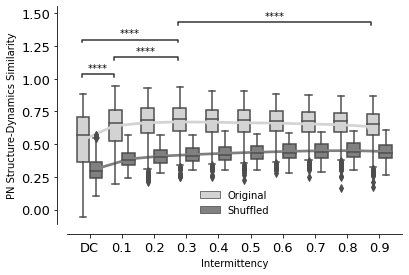

In [9]:
bpx = [((0.0, 'Original'), (0.1, 'Original')),((0.0, 'Original'), (0.3, 'Original')),((0.1, 'Original'), (0.3, 'Original')),
 ((0.3, 'Original'), (0.9, 'Original'))]

df = pd.DataFrame()
for i in filter(lambda v: "PNCorrelationAnalysis" in v,os.listdir('AnalysedData/')):
    temp = pd.read_csv(f"AnalysedData/{i}",index_col=0)
    temp['Intermittency'] = int(i.split('_')[2][:-4])/10
    
    df = pd.concat((df,temp))

df = df.melt('Intermittency',var_name="Neuron Order",value_name="Structure-Dynamics Similarity")
df['Structure-Dynamics Similarity'] = np.real(df['Structure-Dynamics Similarity'])
plt.figure(figsize=(6,4))
mpl.rc('xtick', labelsize=13) 
mpl.rc('ytick', labelsize=13) 
ax = sns.pointplot(x='Intermittency',y='Structure-Dynamics Similarity', data=df,
              palette='blend:lightgrey,grey',ci=None,capsize=0.1, hue='Neuron Order',dodge=0.5)
plt.setp(ax.lines, zorder=1)
plt.setp(ax.collections, zorder=1, label="")
ax = sns.boxplot(x='Intermittency',y='Structure-Dynamics Similarity',
                 data=df,palette='blend:lightgrey,grey', hue='Neuron Order')
sns.despine(offset=10, trim=False)

annotator = Annotator(ax, bpx, data=df, x='Intermittency',y='Structure-Dynamics Similarity',
                                       hue="Neuron Order", width=1)
annotator.configure(test='Wilcoxon', text_format='star', loc='inside', verbose=2,comparisons_correction='bonferroni')
annotator.apply_and_annotate()
ax.legend(frameon=False)
ax.set_ylabel("PN Structure-Dynamics Similarity")
ax.set_xticklabels(["DC", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9"])
plt.savefig(f"Figures/PNCorrelationAnalysis.svg")

100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


Intermittency	p value	Effect Size
DC	****, 8.304e-57	0.840 [95% CI 0.802-0.874]
0.1	****, 1.991e-75	0.966 [95% CI 0.952-0.977]
0.2	****, 1.049e-76	0.974 [95% CI 0.962-0.984]
0.3	****, 7.070e-78	0.981 [95% CI 0.972-0.989]
0.4	****, 3.759e-78	0.983 [95% CI 0.974-0.990]
0.5	****, 6.471e-78	0.981 [95% CI 0.972-0.989]
0.6	****, 2.716e-78	0.984 [95% CI 0.976-0.991]
0.7	****, 2.069e-78	0.984 [95% CI 0.977-0.991]
0.8	****, 5.012e-77	0.976 [95% CI 0.965-0.985]
0.9	****, 3.726e-75	0.964 [95% CI 0.949-0.977]


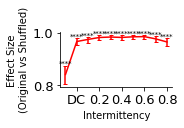

In [10]:
x = []
y = []
yerr = []
p = []
pvals = []
for i in tqdm(np.unique(df.Intermittency)):
    temp = rankbiserial(df[np.logical_and(df.Intermittency==i,df["Neuron Order"]=="Original")]["Structure-Dynamics Similarity"].values,
                    df[np.logical_and(df.Intermittency==i,df["Neuron Order"]=="Shuffled")]["Structure-Dynamics Similarity"].values)
    pval = wilcoxon(df[np.logical_and(df.Intermittency==i,df["Neuron Order"]=="Original")]["Structure-Dynamics Similarity"].values,
    df[np.logical_and(df.Intermittency==i,df["Neuron Order"]=="Shuffled")]["Structure-Dynamics Similarity"].values).pvalue
    pvals.append(500*pval)
    p.append(to_significance_label(500*pval))
    x.append(i)
    y.append(temp[0])
    yerr.append(temp[1])
plt.figure(figsize=(2,1))
plt.errorbar(x,y,yerr=np.abs(np.array(yerr).T-np.tile(y,2).reshape(2,10)),capsize=2,color='red')
for i in range(10):
    plt.text(x[i],np.array(yerr)[:,1][i],p[i],ha='center',fontdict={'size':7})
plt.xticks(np.arange(0.1,1.0,0.2))
plt.xlabel("Intermittency")
plt.ylabel("Effect Size\n(Original vs Shuffled)")
plt.gca().set_xticklabels(["DC",  "0.2",  "0.4",  "0.6",  "0.8"])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.savefig(f"Figures/PNCorrelationAnalysis_effect.svg")

print("Intermittency\tp value\tEffect Size")
for i,n in enumerate(np.unique(df.Intermittency)):
    if n == 0.0:
        print(f"DC\t{p[i]}, {pvals[i]:0.3e}\t{y[i]:0.3f} [95% CI {yerr[i][0]:0.3f}-{yerr[i][1]:0.3f}]")
    else:
        print(f"{n}\t{p[i]}, {pvals[i]:0.3e}\t{y[i]:0.3f} [95% CI {yerr[i][0]:0.3f}-{yerr[i][1]:0.3f}]")

# Odor Specificity across Intermittency (Fig 7e,f)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.7_Across vs. 0.9_Across: Wilcoxon test (paired samples) with Bonferroni correction, P_val:0.000e+00 Stat=9.278e+06
0.0_Across vs. 0.7_Across: Wilcoxon test (paired samples) with Bonferroni correction, P_val:0.000e+00 Stat=4.052e+04


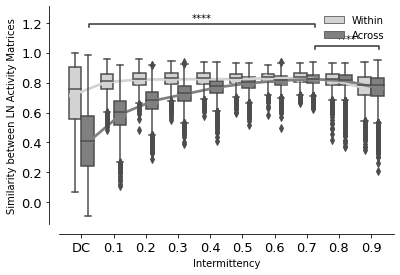

In [11]:
bpx = [((0.0, 'Across'), (0.7, 'Across')),((0.9, 'Across'), (0.7, 'Across'))]

df = pd.DataFrame()
for i in filter(lambda v: "OdorComparision_" in v,os.listdir('AnalysedData/')):
    temp = pd.read_csv(f"AnalysedData/{i}",index_col=0)
    temp['Intermittency'] = int(i.split('_')[2][:-4])/10
    df = pd.concat((df,temp))
t1 = df.drop('Across',axis=1)
t1.columns = ["Correlation","Intermittency"]
t1["Identity"] = "Within"
t2 = df.drop('Within',axis=1)
t2.columns = ["Correlation","Intermittency"]
t2["Identity"] = "Across"
df = pd.concat([t1,t2]).dropna()

plt.figure(figsize=(6,4))
mpl.rc('xtick', labelsize=13) 
mpl.rc('ytick', labelsize=13) 
ax = sns.pointplot(x='Intermittency',y='Correlation', data=df,
              palette='blend:lightgrey,grey',ci=None,capsize=0.1, hue='Identity',dodge=0.5)
plt.setp(ax.lines, zorder=1)
plt.setp(ax.collections, zorder=1, label="")
ax = sns.boxplot(x='Intermittency',y='Correlation',
                 data=df,palette='blend:lightgrey,grey', hue='Identity')
sns.despine(offset=10, trim=False)
annotator = Annotator(ax, bpx, data=df, x='Intermittency',y='Correlation',
                                       hue="Identity", width=1)
annotator.configure(test='Wilcoxon', text_format='star', loc='inside', verbose=2,comparisons_correction='bonferroni')
annotator.apply_and_annotate()
ax.legend(frameon=False)
ax.set_ylabel("Similarity between LN Activity Matrices")
ax.set_xticklabels(["DC", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9"])
plt.savefig(f"Figures/LNOdorDifference.svg")

100%|██████████| 10/10 [02:48<00:00, 16.83s/it]


Intermittency	p value	Effect Size
DC	****, 0.000e+00	0.673 [95% CI 0.657-0.690]
0.1	****, 0.000e+00	0.869 [95% CI 0.861-0.878]
0.2	****, 0.000e+00	0.820 [95% CI 0.810-0.830]
0.3	****, 0.000e+00	0.711 [95% CI 0.697-0.726]
0.4	****, 0.000e+00	0.509 [95% CI 0.490-0.528]
0.5	****, 7.555e-104	0.295 [95% CI 0.273-0.316]
0.6	****, 8.899e-46	0.196 [95% CI 0.175-0.217]
0.7	****, 2.890e-13	0.108 [95% CI 0.086-0.130]
0.8	****, 1.443e-06	0.078 [95% CI 0.056-0.102]
0.9	ns, 5.392e+00	0.031 [95% CI 0.009-0.052]


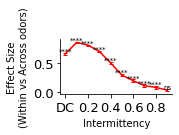

In [12]:
x = []
y = []
yerr = []
p = []
pvals = []
for i in tqdm(np.unique(df.Intermittency)):
    temp = cliffdelta(df[np.logical_and(df.Intermittency==i,df["Identity"]=="Within")]["Correlation"].values,
                    df[np.logical_and(df.Intermittency==i,df["Identity"]=="Across")]["Correlation"].values)
    pval = mannwhitneyu(df[np.logical_and(df.Intermittency==i,df["Identity"]=="Within")]["Correlation"].values,
    df[np.logical_and(df.Intermittency==i,df["Identity"]=="Across")]["Correlation"].values).pvalue
    pvals.append(500*pval)
    p.append(to_significance_label(500*pval))
    x.append(i)
    y.append(temp[0])
    yerr.append(temp[1])
plt.figure(figsize=(2,1))
plt.errorbar(x,y,yerr=np.abs(np.array(yerr).T-np.tile(y,2).reshape(2,10)),capsize=2,color='red')
for i in range(10):
    plt.text(x[i],np.array(yerr)[:,1][i],p[i],ha='center',fontdict={'size':7})
plt.xticks(np.arange(0.0,1.0,0.2))
plt.xlabel("Intermittency")
plt.ylabel("Effect Size\n(Within vs Across odors)")
plt.gca().set_xticklabels(["DC",  "0.2",  "0.4",  "0.6",  "0.8"])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.savefig(f"Figures/LNOdorDifference_effect.svg")

print("Intermittency\tp value\tEffect Size")
for i,n in enumerate(np.unique(df.Intermittency)):
    if n == 0.0:
        print(f"DC\t{p[i]}, {pvals[i]:0.3e}\t{y[i]:0.3f} [95% CI {yerr[i][0]:0.3f}-{yerr[i][1]:0.3f}]")
    else:
        print(f"{n}\t{p[i]}, {pvals[i]:0.3e}\t{y[i]:0.3f} [95% CI {yerr[i][0]:0.3f}-{yerr[i][1]:0.3f}]")

In [13]:
if recalculate:
    emat = np.zeros((len(np.unique(df.Time)),len(np.unique(df.Intermittency))))
    pmat = np.zeros((len(np.unique(df.Time)),len(np.unique(df.Intermittency))))
    for m,t in enumerate(np.unique(df.Time)):
        for n,i in tqdm(enumerate(np.unique(df.Intermittency))):
            temp = df[np.logical_and(df.Time==t,df.Intermittency==i)]
            emat[m,n] = cliffdelta(temp[temp["LN Dynamics Correlation"]=="Within Odors"]["Correlation"].values,
                                temp[temp["LN Dynamics Correlation"]=="Across Odors"]["Correlation"].values)[0]
            pmat[m,n] = mannwhitneyu(temp[temp["LN Dynamics Correlation"]=="Within Odors"]["Correlation"].values,
                                temp[temp["LN Dynamics Correlation"]=="Across Odors"]["Correlation"].values).pvalue
    
    data = pd.DataFrame(emat.T,index=np.unique(df.Intermittency),columns=np.unique(df.Time))
    datap = pd.DataFrame(pmat.T,index=np.unique(df.Intermittency),columns=np.unique(df.Time))
    data.to_csv("AnalysedData/emat.csv")
    datap.to_csv("AnalysedData/pmat.csv")
else:
    data = pd.read_csv("AnalysedData/emat.csv",index_col=0)
    datap = pd.read_csv("AnalysedData/pmat.csv",index_col=0)

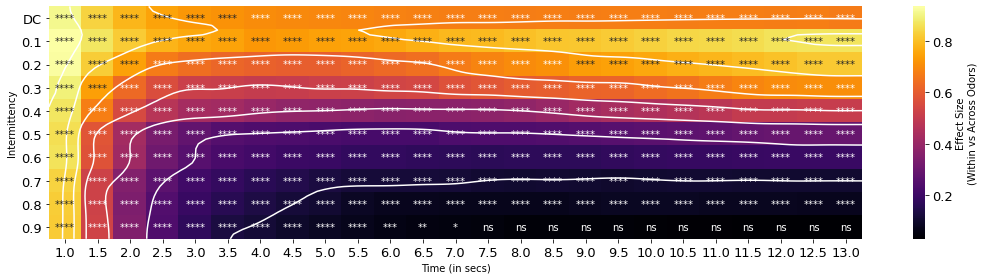

In [14]:
fig, ax = plt.subplots(figsize=(15,4))

smooth_scale = 5
z = ndimage.zoom(data.to_numpy(), smooth_scale)
cntr = ax.contour(np.linspace(0, len(data.columns), len(data.columns) * smooth_scale),
                  np.linspace(0, len(data.index), len(data.index) * smooth_scale),
                  z, levels=np.linspace(0,1,9), colors='white')
ax = sns.heatmap(data, annot=datap.applymap(lambda v: to_significance_label(500*v)), fmt="", cbar=True, ax=ax, cmap='inferno',cbar_kws={'label': 'Effect Size\n(Within vs Across Odors)'})
plt.yticks(rotation=0)
ax.set_yticklabels(["DC", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9"])
plt.xticks(rotation=0) 
plt.xlabel("Time (in secs)")
plt.ylabel("Intermittency")
plt.tight_layout()
plt.savefig(f"Figures/LNOdorEffectTimeseries.svg")
plt.show()